# Import Google Drive

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer as MICE
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchsummary import summary
from sklearn.datasets import make_swiss_roll

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read Dataset

In [39]:
#Read and print the data.csv dataset
data_df = pd.read_excel("/content/drive/MyDrive/NBA_Draft_Prospects_23_21.xlsx")
print(data_df.head())

                                                 URL             NAME  Rd  \
0  https://basketball.realgm.com/player/Efe-Abogi...      Efe Abogidi   0   
1  https://basketball.realgm.com/player/Amari-Bai...     Amari Bailey   2   
2  https://basketball.realgm.com/player/Emoni-Bat...      Emoni Bates   2   
3  https://basketball.realgm.com/player/Tarik-Bib...  Tarik Biberovic   2   
4  https://basketball.realgm.com/player/Anthony-B...    Anthony Black   1   

  PrimPos SecPos  AGE          SCHOOL/CLUB    HEIGHT  WEIGHT         STATUS  \
0       C    NaN   22      G League Ignite  6.833333     225       G League   
1       G    NaN   20                 UCLA  6.250000     191       Freshman   
2       G    NaN   20     Eastern Michigan  6.750000     190      Sophomore   
3       F    NaN   23  Fenerbahce (Turkey)  6.583333     218  International   
4       G    NaN   20             Arkansas  6.416667     210       Freshman   

   ... A-TOV% A-STL%  A-BLK%  A-USG%  A-Total S%  A-PPR  A-PPS

# Clean Data

In [40]:
# drop URL, NAME, duplicate GP, GS
data2_df = data_df.drop(columns=['URL', 'NAME', 'GP.1', 'GS.1', 'GP.2', 'GP.3'])

# convert positions to values
# print(data2_df['PrimPos'].unique())
# print(data2_df['SecPos'].unique())
d = {'C':1, 'G':2, 'F':3}   #['C' 'G' 'F']
data2_df['PrimPos'] = data2_df['PrimPos'].map(d)
data2_df['SecPos'] = data2_df['SecPos'].map(d)
data2_df['SecPos'].fillna(0, inplace=True)

# convert SCHOOL/CLUB to values
# print(len(data2_df['SCHOOL/CLUB'].unique()))
# print(data2_df['SCHOOL/CLUB'].unique())
d2 = {'G League Ignite':1, 'UCLA':125, 'Eastern Michigan':2, 'Fenerbahce (Turkey)':3,
 'Arkansas':4, 'Missouri':5, 'Michigan':6, 'Dayton':7, 'Florida':8, 'Alabama':9,
 'Metropolitans 92 (France)':10, 'Kansas':11, 'Mega Bemax (Belgium)':12, 'Princeton':13,
 'Baylor':14, 'Overtime Elite':15, 'Washington State':16, 'Connecticut':17,
 'Central Florida':18, 'Indiana':19, 'Studentski Centar (Montenegro)':20,
 'South Carolina':21, 'Kansas State':22, 'Xavier':23, 'Pepperdine':24, 'Duke':25, 'Kentucky':26,
 'Penn State':27, 'TCU':28, 'Miami':29, 'San Jose State':30, 'Iowa':31, 'FC Barcelona (Spain)':32,
 'Tennessee':33, 'Santa Clara':34, 'Marquette':35, 'NZ Breakers (New Zealand)':36,
 'Houston':37, 'Creighton':38, 'Ohio State':39, 'Belmont':40, 'Furman':41, 'N.C. State':42,
 'Gonzaga':43, 'Arizona':44, 'Clemson':45, 'Partizan Mozzart Bet Belgrade (Serbia)':46,
 'Villanova':47, 'Forca Lleida CE (Spain)':48, 'Milwaukee':49, 'Team Overtime':50,
 'New Zealand Breakers (NZ)':51, 'University of San Francisco':52,
 'Michigan State':53, 'Murray State':54, 'Florida State':55, "St. John's":56, 'Illinois':57,
 'Wisconsin':58, 'Gran Canaria (Spain)':59, 'Memphis':60, 'LSU':61, "St. Jospeh's":62,
 'Rutgers':63, 'Melbourne United':64, 'Purdue':65, 'Mega Mozzart (Serbia)':66,
 'Paris Basketball (France)':67, 'Auburn':68, 'Wake Forest':69, 'UConn':122, 'Nebraska':70,
 'Fort Erie International Academy':71, 'University of Southern California':72,
 'Georgetown':76, 'Mississippi State':73, 'Unicaja Malaga (Spain)':74, 'Vanderbilt':75,
 'Fortitudo Bologna':77, 'Fresno State':78, 'Colorado State':79, 'Toledo':80,
 'Minas (Brazil)':81, 'North Carolina State':82, 'Adelaide 36ers (Australia)':83,
 'Vanoli Cremona (Italy)':84, 'Perth (Austrailia)':85, 'Colorado':123, 'Notre Dame':86,
 'Texas Tech':87, 'VCU':88, 'Zhejiang Chouzhou (China)':89, 'Loyola (MD)':90,
 'Boise State':91, 'Western Kentucky':92, 'Port of Antwerp Giants (Belgium)':93,
 'Texas':94, 'Pittsburgh':95, 'Arizona State':96, 'Oklahoma State':126, 'Oregon':97,
 'Providence':98, 'CB Girona (Spain)':99, 'Real Madrid':100, 'Adelaide (Australia)':101,
 'Syracuse':102, 'Virginia':103, 'Louisville':104, 'Zalgiris Kaunas (Lithuania)':105,
 'Panathinaikos (Greece)':106, 'South Caroilna':107, 'Seton Hall':124, 'West Virginia':108,
 'San Diego State':109, 'USC':110, 'Mega Basket (Serbia)':111, 'Ohio':112, 'Utah State':113,
 'Oklahoma':114, 'Besiktas (Turkey)':1115, 'North Carolina':116,
 'Telenet BC Oostende (Belgium)':117, 'DePaul':118, 'Maryland':119, 'Stanford':120,
 'Georgia Tech':121}
data3_df = data2_df.copy()
data3_df['SCHOOL/CLUB'] = data3_df['SCHOOL/CLUB'].map(d2)

# convert STATUS to values
# print(len(data3_df['STATUS'].unique()))
# print(data3_df['STATUS'].unique())
d3 = {'G League':5, 'Freshman':1, 'Sophomore':2, 'International':9, 'Senior':4, 'Junior':3,
 'Overtime Elite':6, 'Draft Eligibile':7, 'Draft Eligible':7, 'Post-Graduate':8,
 'Sophmore':2}
data3_df['STATUS'] = data3_df['STATUS'].map(d3)

# convert COUNTRY to values
# print(len(data3_df['COUNTRY'].unique()))
# print(data3_df['COUNTRY'].unique())
d4 = {'Nigeria':2, 'USA':1, 'Turkey':3, 'Belgium':4, 'France':5, 'England':6, 'Senegal':7, 'Croatia':8,
 'New Zealand':9, 'Canada':10, 'Mali':11, 'Democratic Republic of the Congo':12,
 'Lithuania':13, 'Serbia':14, 'United States':15, 'Australia':16, 'Germany':17, 'Cameroon':18,
 'Bosnia and Herzegovina':19, 'Jamaica':20, 'Panama':21, 'Dominican Republic':22,
 'DR Congo':23, 'Italy':24, 'Brazil':25, 'Poland':26, 'Philippines':27, 'Austraila':28, 'China':29,
 'Spain':30, 'Guadeloupe':31, 'Bahamas':32, 'Greece':33, 'DRC':34, 'Georgia / USA':35, 'Haiti':36,
 'Portugal':37}
data3_df['COUNTRY'] = data3_df['COUNTRY'].map(d4)

# remove comments
# print(data3_df['GP'].unique())
for i in range(0, len(data3_df['GP'])):
  if data3_df.loc[i,"GP"] == 'No NCAA data':
    data3_df.loc[i,"GP"] = 'NaN'
# print(data3_df['GP'].unique())
# print(data3_df.head())
# print(data3_df.tail())

#limit drafted and undrafted
d5 = {0:0, 1:1, 2:1}
data3_df['Rd'] = data3_df['Rd'].map(d5)
# print(data3_df.head())

# Missing Data Eval

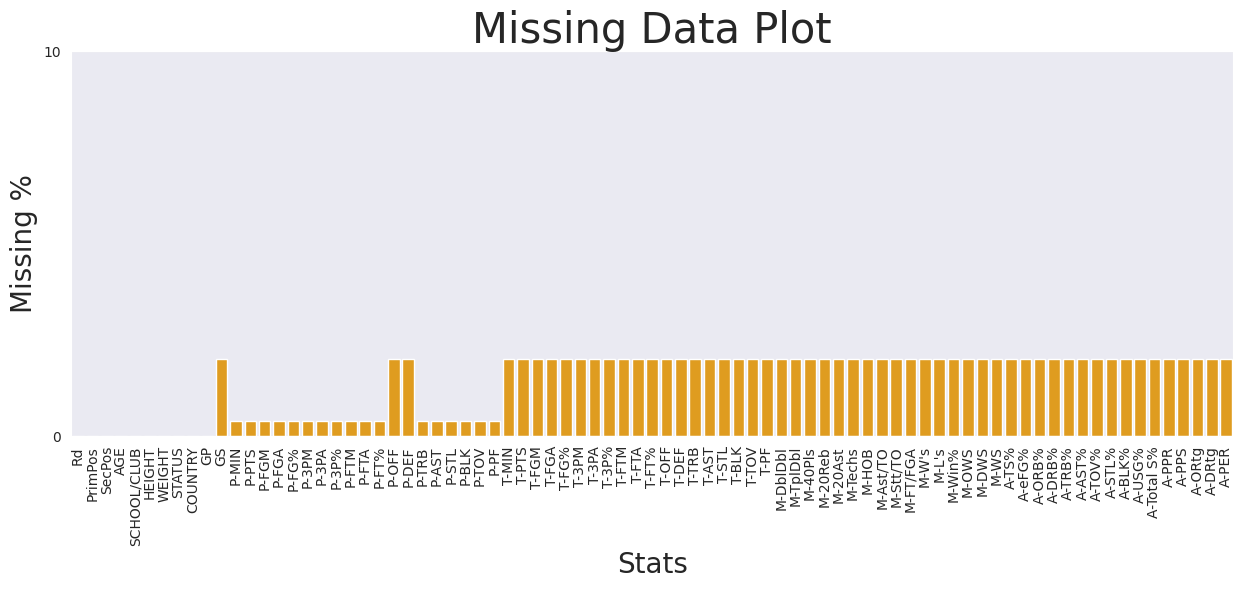

In [41]:
# Eval missing value for each column again
nan_per_column = pd.DataFrame(data3_df.isna().sum(),columns=['nanValues']).reset_index()

# Calculate NaN %
for i in range(0,len(nan_per_column)):
    nan_per_column.loc[i, 'nanValuesPct'] = 100*round(nan_per_column.loc[i, 'nanValues']/len(data3_df),3)

# Plot - % of missing rows for each column
sns.set_style("darkgrid")
plt.figure(figsize=(15,5))
sns.barplot(x="index", y="nanValuesPct", data=nan_per_column, color="orange")
plt.xlabel('Stats', fontsize=20)
plt.ylabel('Missing %', fontsize=20)
plt.title('Missing Data Plot', fontsize=30)
plt.yticks([0,10])  # ,20,30,40,50,60,70,80,90,100
plt.xticks(rotation=90);

# Way 1: imputation

In [42]:
# imputation data
if 1 == 0:
  data4_df = data3_df.copy()
  data5_df = MICE(max_iter=150, verbose=1, random_state=1206).fit_transform(data4_df.values)
  data6_df = pd.DataFrame(data=data5_df, columns=data4_df.columns, index=data4_df.index)

  # output cleaned data
  data6_df.to_excel("/content/drive/MyDrive/NBA_Draft_Prospects_23_21_clean_mice.xlsx", index=False)

# Way 2: drop 5 players among 248.

In [43]:
if 1 == 1:
  data4_df = data3_df.copy()
  data6_df = data4_df.drop([19, 59, 60, 128, 140])

  # output cleaned data
  data6_df.to_excel("/content/drive/MyDrive/NBA_Draft_Prospects_23_21_clean_drop.xlsx", index=False)

In [ ]:
# # Exclude rows with 'G League' and 'International' status
# df = original_df[(original_df['STATUS'] != 'G League') & (original_df['STATUS'] != 'International')]
# # print(df['STATUS'])

# #Change string values into numerical values
# d = {'Freshman':1, 'Sophomore':2, 'Junior':3, 'Senior':4}
# df['STATUS'] = df['STATUS'].map(d)
# # print(df['STATUS'])

# # Convert school names to numerical identifiers
# school_ids = {school: idx for idx, school in enumerate(df['SCHOOL/CLUB'].unique(), start=1)}
# df['School'] = df['SCHOOL/CLUB'].map(school_ids)

# df = df.drop(columns=['Player','POS','HEIGHT','COUNTRY','SCHOOL/CLUB'])

# # Print the DataFrame with the new 'School_ID' column
# print(df.head())


# Correlation Heatmap

19


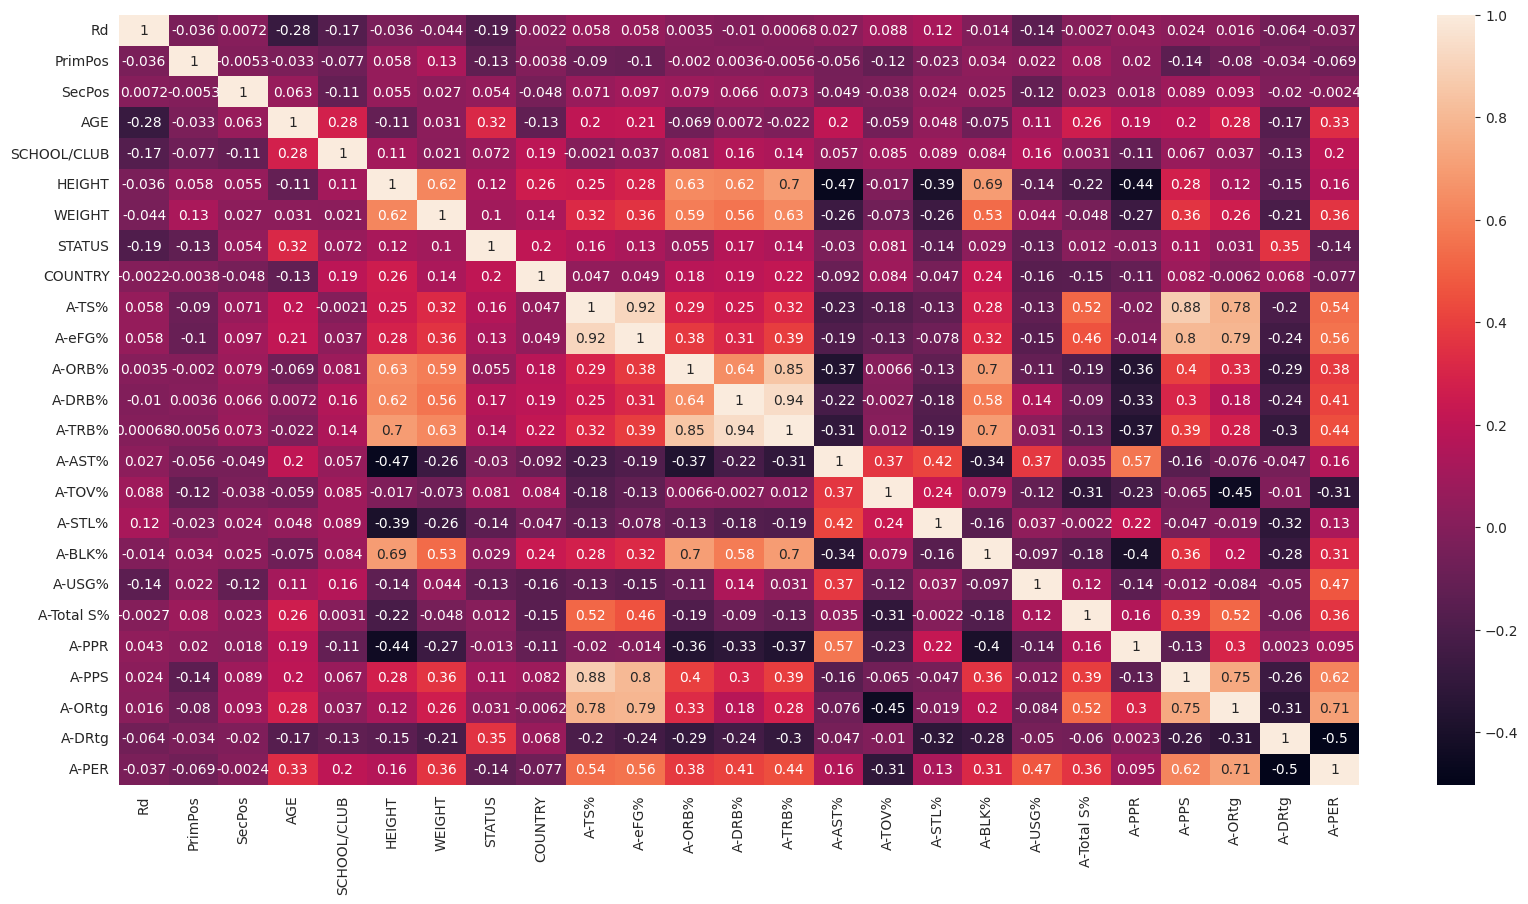

In [44]:
data7_df = data6_df.copy()    #[data6_df['PrimPos'] == 3]
# print(len(data7_df.columns))
# data7_df = data7_df.drop(columns=[
#        'T-MIN', 'T-PTS', 'T-FGM', 'T-FGA', 'T-FG%', 'T-3PM', 'T-3PA',
#        'T-3P%', 'T-FTM', 'T-FTA', 'T-FT%', 'T-OFF', 'T-DEF', 'T-TRB', 'T-AST',
#        'T-STL', 'T-BLK', 'T-TOV', 'T-PF',
#        'M-DblDbl', 'M-TplDbl', 'M-40Pls', 'M-20Reb', 'M-20Ast', 'M-Techs',
#        'M-HOB', 'M-Ast/TO', 'M-Stt/TO', 'M-FT/FGA', 'M-W\'s', 'M-L\'s',
#        'M-Win%', 'M-OWS', 'M-DWS', 'M-WS',
#        'A-TS%', 'A-eFG%', 'A-ORB%', 'A-DRB%', 'A-TRB%',
#        'A-AST%', 'A-TOV%', 'A-STL%', 'A-BLK%', 'A-USG%', 'A-Total S%', 'A-PPR',
#        'A-PPS', 'A-ORtg', 'A-DRtg', 'A-PER'
#        ])
# old features
phy_stats = ['Rd', 'PrimPos', 'SecPos', 'AGE', 'SCHOOL/CLUB', 'HEIGHT', 'WEIGHT',
       'STATUS', 'COUNTRY']
pgm_stats = ['GP', 'GS', 'P-MIN', 'P-PTS', 'P-FGM', 'P-FGA',
       'P-FG%', 'P-3PM', 'P-3PA', 'P-3P%', 'P-FTM', 'P-FTA', 'P-FT%', 'P-OFF',
       'P-DEF', 'P-TRB', 'P-AST', 'P-STL', 'P-BLK', 'P-TOV', 'P-PF']
tgm_stats = ['T-MIN', 'T-PTS', 'T-FGM', 'T-FGA', 'T-FG%', 'T-3PM', 'T-3PA',
       'T-3P%', 'T-FTM', 'T-FTA', 'T-FT%', 'T-OFF', 'T-DEF', 'T-TRB', 'T-AST',
       'T-STL', 'T-BLK', 'T-TOV', 'T-PF']
misc_stats = ['M-DblDbl', 'M-TplDbl', 'M-40Pls', 'M-20Reb', 'M-20Ast', 'M-Techs',
       'M-HOB', 'M-Ast/TO', 'M-Stt/TO', 'M-FT/FGA', 'M-W\'s', 'M-L\'s',
       'M-Win%', 'M-OWS', 'M-DWS', 'M-WS']
advn_stats =['A-TS%', 'A-eFG%',
       'A-ORB%', 'A-DRB%', 'A-TRB%', 'A-AST%', 'A-TOV%', 'A-STL%', 'A-BLK%',
       'A-USG%', 'A-Total S%', 'A-PPR', 'A-PPS', 'A-ORtg', 'A-DRtg', 'A-PER']
# Correlation calculation
spearman_corr = data7_df[phy_stats+advn_stats].corr('spearman')
# Plot
plt.figure(figsize=(20,10))
sns.heatmap(spearman_corr, annot = True);
print(len(tgm_stats))

# new features
new_pgm_stats = ['GP', 'GS', 'P-MIN', 'P-PTS',
       'P-FG%', 'P-3PM', 'P-3P%', 'P-FTM', 'P-FT%', 'P-OFF',
       'P-DEF', 'P-AST', 'P-STL', 'P-BLK', 'P-TOV', 'P-PF']
new_misc_stats1 = ['M-20Ast']
new_misc_stats2 = ['M-DblDbl', 'M-TplDbl', 'M-40Pls', 'M-20Reb', 'M-Techs',
       'M-HOB', 'M-Ast/TO', 'M-Stt/TO', 'M-FT/FGA', 'M-W\'s', 'M-L\'s',
       'M-Win%', 'M-OWS', 'M-DWS']
new_advn_stats =['A-TS%','A-ORB%', 'A-DRB%', 'A-AST%', 'A-TOV%', 'A-STL%', 'A-BLK%',
       'A-USG%', 'A-Total S%', 'A-PPR', 'A-PPS', 'A-ORtg', 'A-DRtg', 'A-PER']

# # Correlation calculation
# spearman_corr = data7_df[phy_stats+new_pgm_stats+new_misc_stats2+new_advn_stats].corr('spearman')
# # Plot
# plt.figure(figsize=(20,10))
# sns.heatmap(spearman_corr, annot = True);

# Decision Tree Model

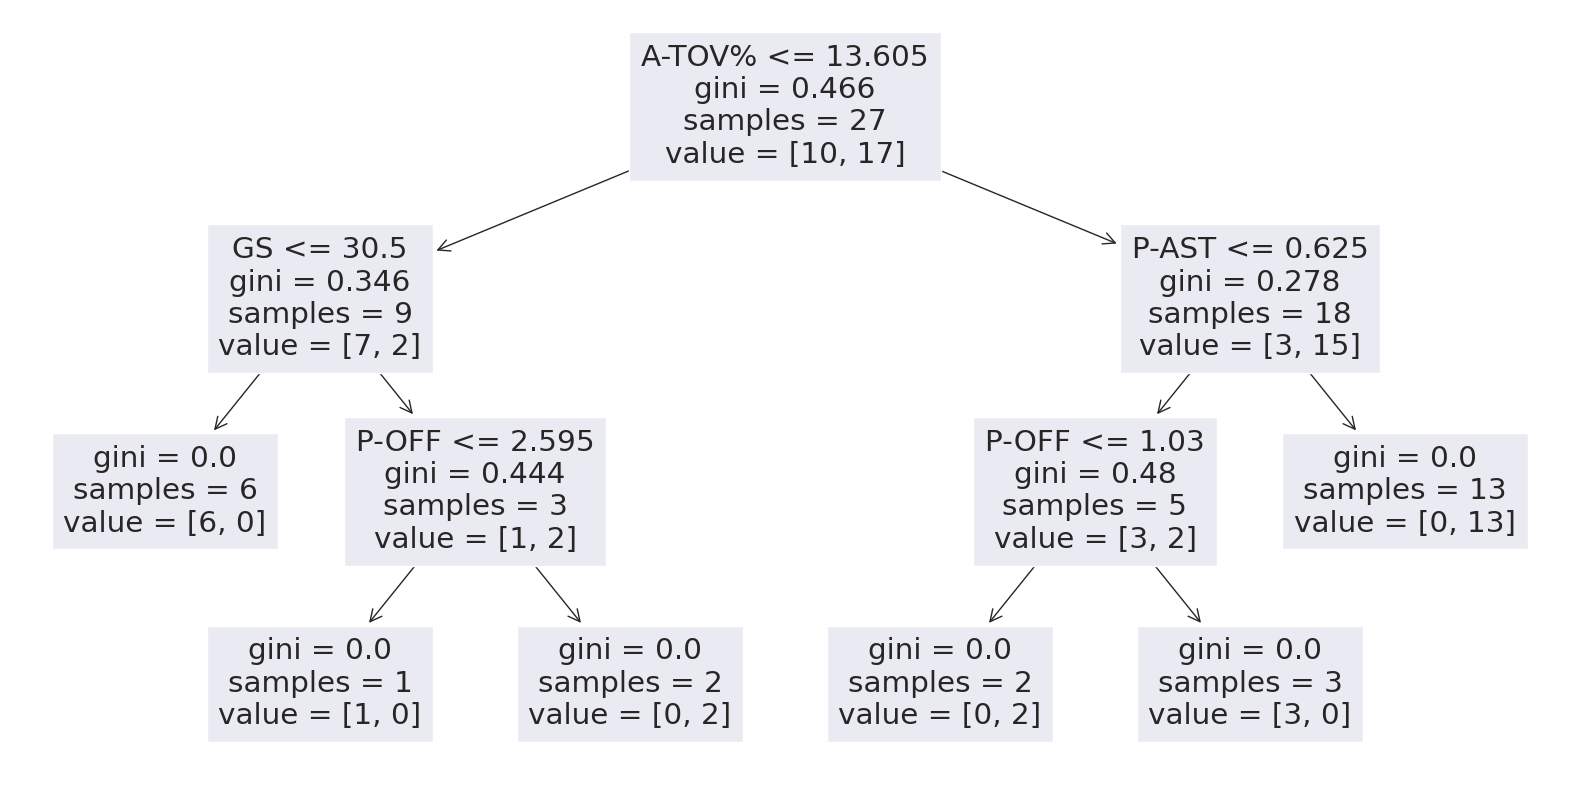

Center Accuracy: 0.7142857142857143


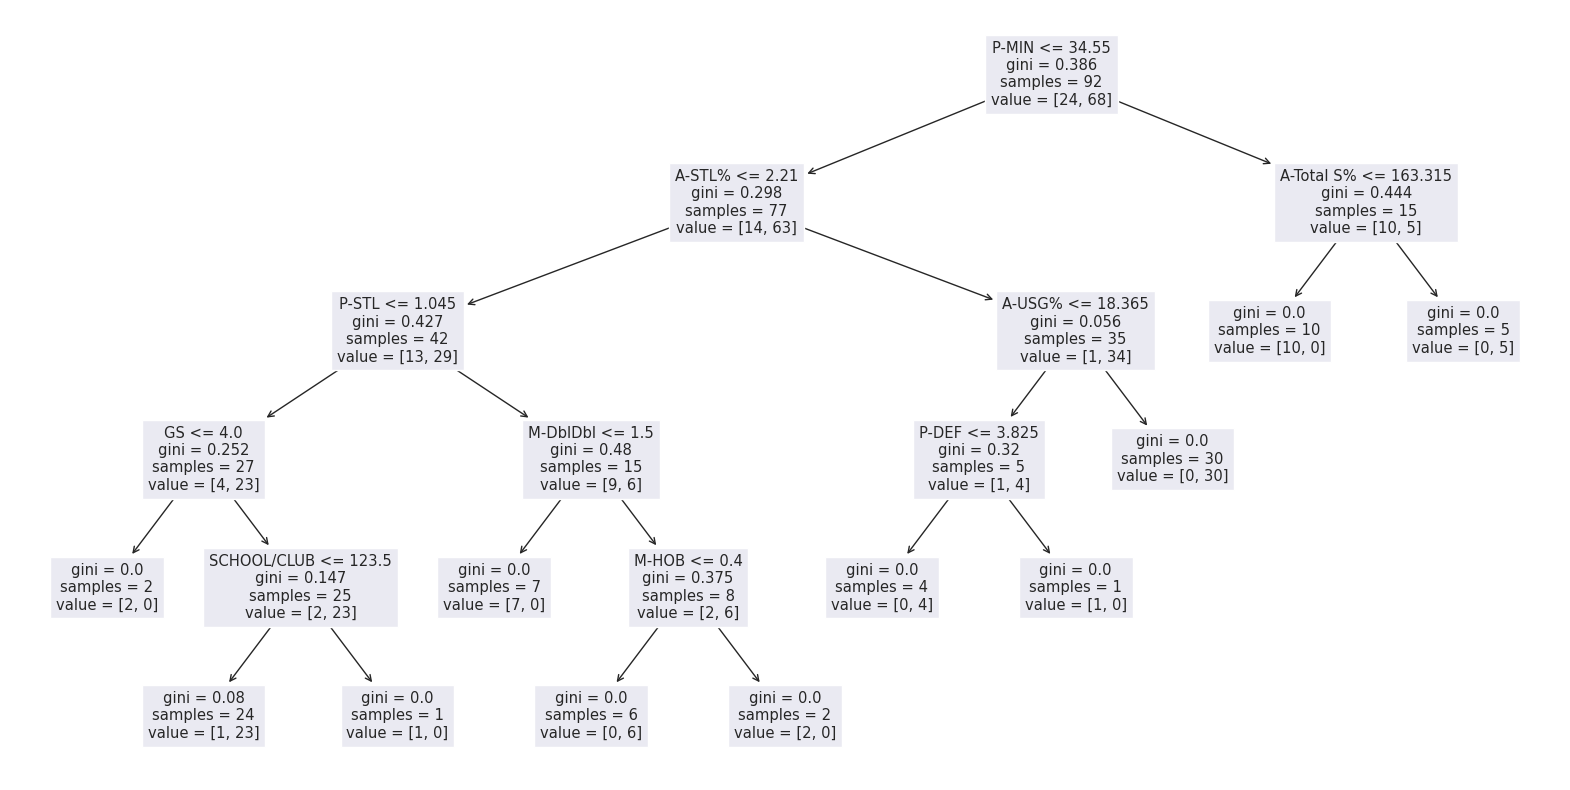

Guard Accuracy: 0.5


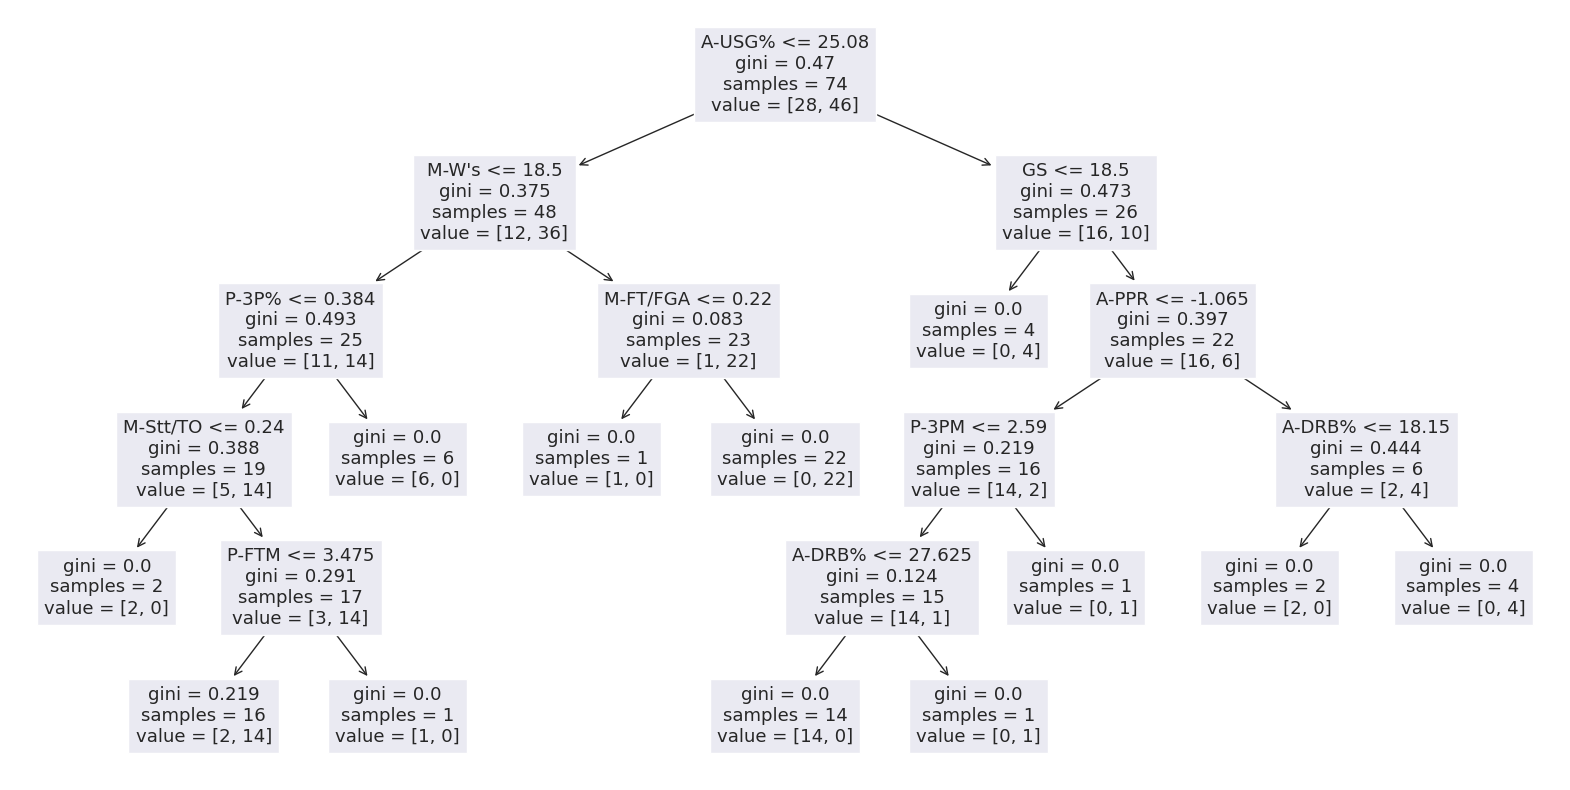

Forward Accuracy: 0.5263157894736842


In [50]:
for i in range(1,4):
  df = data7_df[data7_df['PrimPos'] == i]
  # print(df)

  # features = df.columns.tolist()
  features = phy_stats+new_pgm_stats+new_misc_stats2+new_advn_stats
  features.remove('Rd')
  features.remove('PrimPos')
  # print(len(features))

  x = df[features]
  y = df['Rd']
  # print(x)
  # print(y)
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  dtree_object = DecisionTreeClassifier(max_depth=5) # max_depth=5
  dtree_model = dtree_object.fit(x_train,y_train)

  plt.figure(figsize=(20,10))
  # tree.plot_tree(dtree_model, feature_names = features)
  tree.plot_tree(dtree_model, feature_names=[str(x) for x in features])
  plt.show()

  # Use the trained model to make predictions on the test set
  y_pred = dtree_model.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)
  if i == 3:
    print("Forward Accuracy:", accuracy)
  if i == 1:
    print("Center Accuracy:", accuracy)
  if i == 2:
    print("Guard Accuracy:", accuracy)

# KNN Model

In [57]:

for i in range(1,4):
  df = data7_df[data7_df['PrimPos'] == i]
  # print(df.head())
  # print(df.tail())

  features = phy_stats+new_pgm_stats+new_misc_stats2+new_advn_stats
  features.remove('Rd')
  features.remove('PrimPos')
  # print(features)

  x = df[features]
  y = df['Rd']
  # print(x)
  # print(y)
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  #Train KNN
  KNN = KNeighborsClassifier(n_neighbors=5)
  KNN = KNN.fit(x_train,y_train)

  # dtree_object = DecisionTreeClassifier(max_depth=5)
  # dtree_model = dtree_object.fit(x_train,y_train)

  # plt.figure(figsize=(20,10))
  # tree.plot_tree(KNN, feature_names=[str(x) for x in features])
  # plt.show()

  # Use the trained model to make predictions on the test set
  y_pred = KNN.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)

  if i == 3:
    print("Forward Accuracy:", accuracy)
  if i == 1:
    print("Center Accuracy:", accuracy)
  if i == 2:
    print("Guard Accuracy:", accuracy)

Center Accuracy: 0.7142857142857143
Guard Accuracy: 0.7083333333333334
Forward Accuracy: 0.5789473684210527


# DNN Model

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 40]           2,080
           Sigmoid-2                   [-1, 40]               0
            Linear-3                    [-1, 2]              80
Total params: 2,160
Trainable params: 2,160
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
Epoch: 1
Train Acc: 0.607, Val Acc: 0.667 Train Loss: 0.675, Val Loss: 0.658
Best Acc: 0.667 at epoch: 1

Epoch: 2
Train Acc: 0.607, Val Acc: 0.667 Train Loss: 0.671, Val Loss: 0.656
Best Acc: 0.667 at epoch: 1

Epoch: 3
Train Acc: 0.607, Val Acc: 0.667 Train Loss: 0.667, Val Loss: 0.652
Best Acc: 0.667 at epoch: 1

Epoch: 4
Train Acc: 0.607, Val Acc: 0.667 Tr

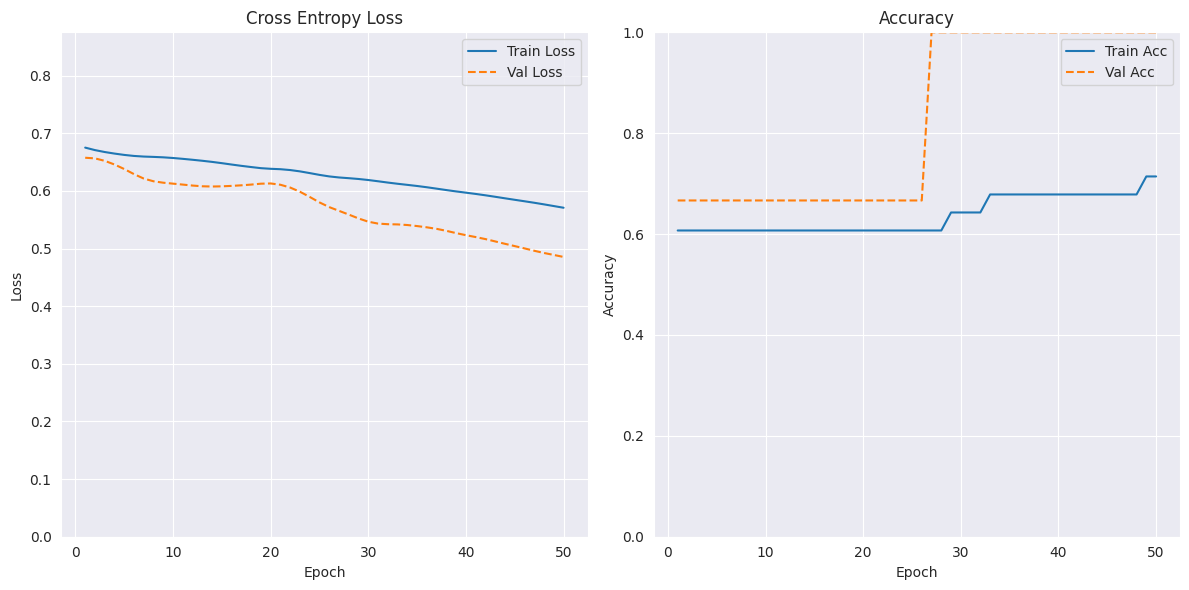

Center test accuracy : 0.667, test loss : 0.642
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 40]           2,080
           Sigmoid-2                   [-1, 40]               0
            Linear-3                    [-1, 2]              80
Total params: 2,160
Trainable params: 2,160
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
Epoch: 1
Train Acc: 0.293, Val Acc: 0.333 Train Loss: 0.867, Val Loss: 0.802
Best Acc: 0.333 at epoch: 1

Epoch: 2
Train Acc: 0.297, Val Acc: 0.417 Train Loss: 0.763, Val Loss: 0.732
Best Acc: 0.417 at epoch: 2

Epoch: 3
Train Acc: 0.502, Val Acc: 0.500 Train Loss: 0.698, Val Loss: 0.693
Best Acc: 0.500 at epoch:

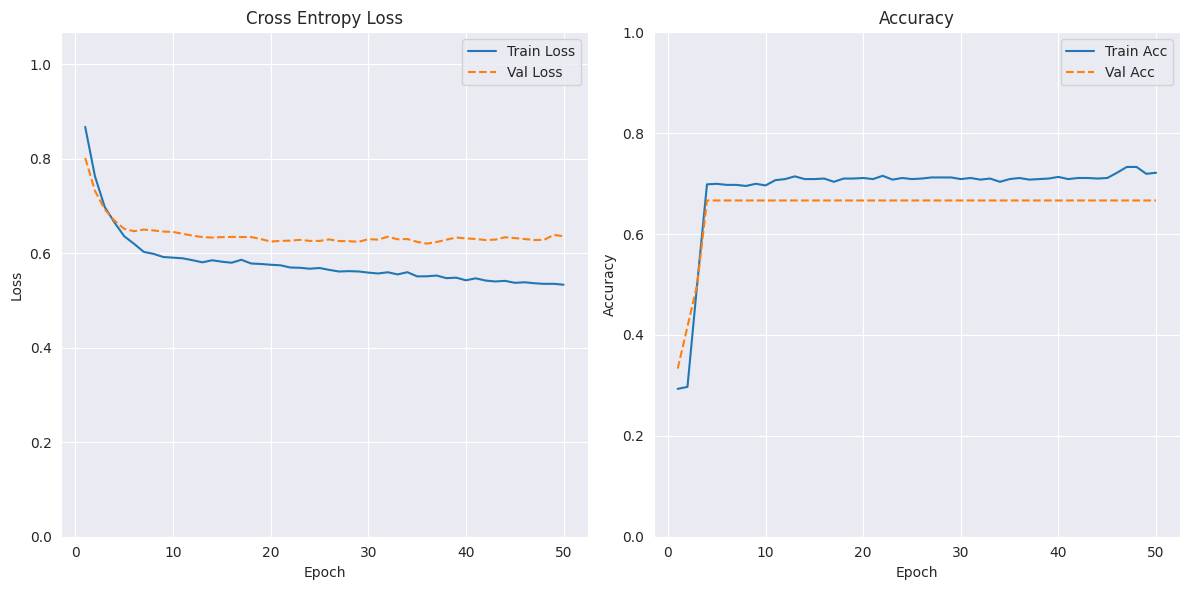

Guard test accuracy : 0.818, test loss : 0.615
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 40]           2,080
           Sigmoid-2                   [-1, 40]               0
            Linear-3                    [-1, 2]              80
Total params: 2,160
Trainable params: 2,160
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
Epoch: 1
Train Acc: 0.442, Val Acc: 0.333 Train Loss: 0.779, Val Loss: 0.879
Best Acc: 0.333 at epoch: 1

Epoch: 2
Train Acc: 0.442, Val Acc: 0.333 Train Loss: 0.740, Val Loss: 0.828
Best Acc: 0.333 at epoch: 1

Epoch: 3
Train Acc: 0.343, Val Acc: 0.333 Train Loss: 0.735, Val Loss: 0.783
Best Acc: 0.333 at epoch: 

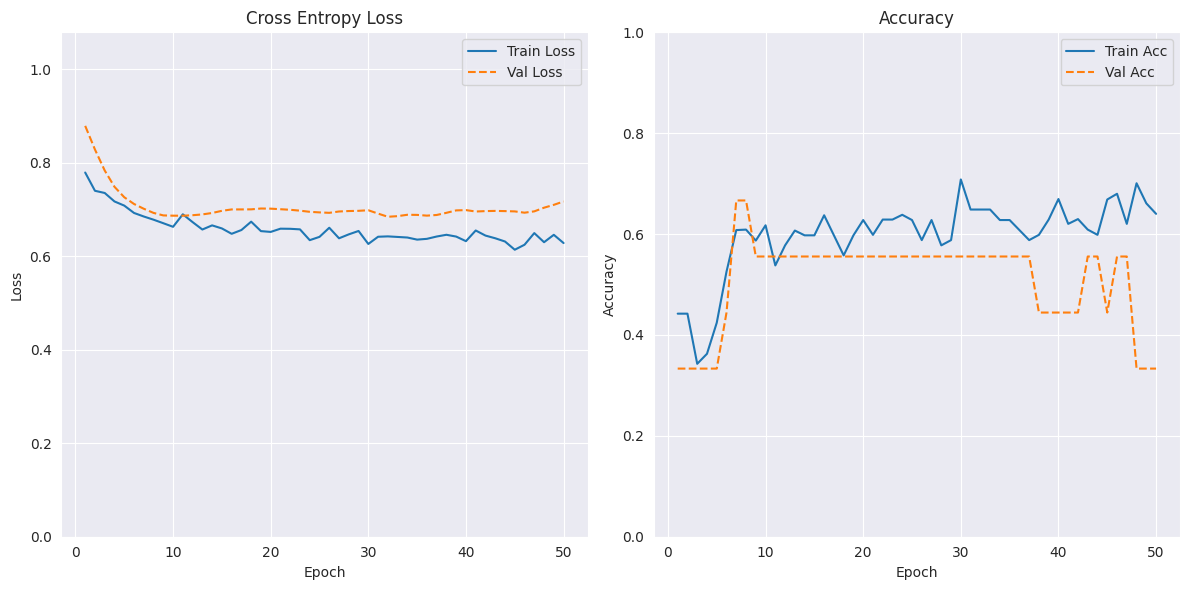

Forward test accuracy : 0.889, test loss : 0.616


In [70]:

for i in range(1,4):
  df = data7_df[data7_df['PrimPos'] == i]
  # print(df)
  features = phy_stats+new_pgm_stats+new_misc_stats2+new_advn_stats
  features.remove('Rd')
  features.remove('PrimPos')
  # print(len(features))

  data = df[features].to_numpy().astype(float)
  labels = df['Rd'].to_numpy()
  # print(data)
  # print(labels)

  # # Plot the data
  # labels_unique = np.unique(labels)
  # for label in labels_unique:
  #     subset = data[labels == label]
  #     plt.scatter(subset[:, 0], subset[:, 1], label=f'Class {label}')

  # plt.title('Data plotted by label')
  # plt.xlabel('x')
  # plt.ylabel('y')
  # plt.legend()
  # plt.show()

  # Convert the data and labels to tensors
  data_tensor = torch.tensor(data, dtype=torch.float32)
  labels_tensor = torch.tensor(labels, dtype=torch.long)
  dataset = TensorDataset(data_tensor, labels_tensor)

  # Split into train/validation/test sets
  train_size = 0.8
  val_size = test_size = 0.1

  train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

  # Create Dataloader objects for train and validation
  batch_size = 32

  train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dl = DataLoader(val_dataset, batch_size=batch_size)

  # 1 hidden layer
  # Set device
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print(device)

  # Define model
  class MyModel(nn.Module):
      def __init__(self):
          super(MyModel, self).__init__()
          # <define the layers to apply in your model here>
          self.fc1 = nn.Linear(in_features=len(features), out_features=40, bias=True)
          self.sigmoid1 = nn.Sigmoid()
          self.fc2 = nn.Linear(in_features=40, out_features=2, bias=False)

      def forward(self, x):
          # <define the forward function here>
          fc1_out = self.fc1(x)
          sigmoid1_out = self.sigmoid1(fc1_out)
          fc2_out = self.fc2(sigmoid1_out)
          return fc2_out

  # Load the model to the device
  model = MyModel().to(device)

  summary(model, (len(features),))

  # Set the loss function
  criterion = nn.CrossEntropyLoss()

  # Set the optimizer
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # Save metrics at each training epoch for plotting
  epoch_train_loss_values = []
  epoch_val_loss_values = []
  epoch_train_acc_values = []
  epoch_val_acc_values = []

  # Define the number of epochs to run
  epochs = 50

  # Using validation accuracy as metric
  best_metric = -1
  best_epoch = 0

  for epoch in range(epochs):

      model.train()  # Set model to training mode

      train_losses, train_accuracies = [], []

      for data, label in train_dl:
          # print(f"Labels: {label}")
          data, label = data.to(device), label.to(device)  # Move data to the same device as the model

          optimizer.zero_grad()  # Clear previous epoch's gradients
          output = model(data)  # Forward pass
          loss = criterion(output, label)  # Compute loss
          loss.backward()  # Backward pass
          optimizer.step()  # Update weights

          # Accumulate metrics
          acc = (output.argmax(dim=1) == label).float().mean().item()
          train_losses.append(loss.item())
          train_accuracies.append(acc)

      # Average metrics across all training steps
      epoch_train_loss = sum(train_losses) / len(train_losses)
      epoch_train_accuracy = sum(train_accuracies) / len(train_accuracies)

      # Save current epochs training metrics
      epoch_train_loss_values.append(epoch_train_loss)
      epoch_train_acc_values.append(epoch_train_accuracy)

      # Validation
      model.eval()  # Set model to evaluation mode
      val_losses, val_accuracies = [], []
      with torch.no_grad():  # Disable gradient calculation
          for data, label in val_dl:
              data, label = data.to(device), label.to(device)

              val_output = model(data)
              val_output = torch.squeeze(val_output)
              val_loss = criterion(val_output, label)

              # Accumulate metrics
              acc = (val_output.argmax(dim=1) == label).float().mean().item()
              val_losses.append(val_loss.item())
              val_accuracies.append(acc)

      # Average metrics across all validation steps
      epoch_val_loss = sum(val_losses) / len(val_losses)
      epoch_val_accuracy = sum(val_accuracies) / len(val_accuracies)

      # Save current epochs validation metrics
      epoch_val_loss_values.append(epoch_val_loss)
      epoch_val_acc_values.append(epoch_val_accuracy)

      # Update best model if validation accuracy improves
      if epoch_val_accuracy > best_metric:
          best_metric = epoch_val_accuracy
          best_epoch = epoch + 1
          torch.save(model.state_dict(), 'best_model.pth')

      print(f'Epoch: {epoch + 1}\n'
            f'Train Acc: {epoch_train_accuracy:.3f}, Val Acc: {epoch_val_accuracy:.3f} '
            f'Train Loss: {epoch_train_loss:.3f}, Val Loss: {epoch_val_loss:.3f}')
      print(f'Best Acc: {best_metric:.3f} at epoch: {best_epoch}\n')

  # Plot results
  plt.figure(figsize=(12, 6))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.title("Cross Entropy Loss")
  plt.ylim(0, max(max(epoch_train_loss_values), max(epoch_val_loss_values)) + 0.2)
  x_train = [i + 1 for i in range(len(epoch_train_loss_values))]
  y_train = epoch_train_loss_values
  x_val = [i + 1 for i in range(len(epoch_val_loss_values))]
  y_val = epoch_val_loss_values
  plt.plot(x_train, y_train, label='Train Loss')
  plt.plot(x_val, y_val, label='Val Loss', linestyle='--')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.title("Accuracy")
  plt.ylim(0, 1)
  x_train_acc = [i + 1 for i in range(len(epoch_train_acc_values))]
  y_train_acc = epoch_train_acc_values
  x_val_acc = [i + 1 for i in range(len(epoch_val_acc_values))]
  y_val_acc = epoch_val_acc_values
  plt.plot(x_train_acc, y_train_acc, label='Train Acc')
  plt.plot(x_val_acc, y_val_acc, label='Val Acc', linestyle='--')
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()

  plt.tight_layout()
  plt.show()

  # Test
  test_dl = DataLoader(test_dataset, batch_size=batch_size)

  # Load saved model parameters
  model.load_state_dict(torch.load('best_model.pth'))

  # Test Loop
  model.eval()

  with torch.no_grad():
      total_accuracy, total_test_loss = 0.0, 0.0
      num_batches = len(test_dl)

      for data, label in test_dl:
          data, label = data.to(device), label.to(device)

          output = model(data)
          loss = criterion(output, label)
          accuracy = (output.argmax(dim=1) == label).float().mean()

          total_test_loss += loss.item()
          total_accuracy += accuracy.item()

      avg_loss = total_test_loss / num_batches
      avg_accuracy = total_accuracy / num_batches

      if i == 3:
        print(f'Forward test accuracy : {avg_accuracy:.3f}, test loss : {avg_loss:.3f}')
      if i == 1:
        print(f'Center test accuracy : {avg_accuracy:.3f}, test loss : {avg_loss:.3f}')
      if i == 2:
        print(f'Guard test accuracy : {avg_accuracy:.3f}, test loss : {avg_loss:.3f}')


# MLP Model

In [84]:

for i in range(1,4):
  df = data7_df[data7_df['PrimPos'] == i]
  # print(data8_df.columns)
  # features = phy_stats+new_pgm_stats+new_misc_stats2+new_advn_stats
  X = df[phy_stats+new_pgm_stats]
  X = X.drop(columns=['Rd'])
  X = X.drop(columns=['PrimPos'])
  # X = X.drop(columns=['SecPos'])
  # print(len(X.columns))
  y = df['Rd']

  # print(X)
  # print(y)

  # Split data into train and test sets
  # from sklearn.model_selection import train_test_split

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # from sklearn.neural_network import MLPClassifier

  # Create MLPClassifier
  mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42) # hidden_layer_sizes=(100, 50), max_iter=500, random_state=42
  mlp.fit(X_train, y_train)

  # Predict
  y_predict_mlp_train = mlp.predict(X_train)
  y_predict_mlp_test = mlp.predict(X_test)

  # from sklearn.metrics import accuracy_score
  accuracy_train = accuracy_score(y_train, y_predict_mlp_train)
  accuracy_test = accuracy_score(y_test, y_predict_mlp_test)
  if i==1:
    print("Center accuracy on training data:", accuracy_train)
    print("Center accuracy on test data:", accuracy_test)
  if i==2:
    print("Guard accuracy on training data:", accuracy_train)
    print("Guard accuracy on test data:", accuracy_test)
  if i==3:
    print("Forward accuracy on training data:", accuracy_train)
    print("Forward accuracy on test data:", accuracy_test)


Center accuracy on training data: 1.0
Center accuracy on test data: 0.7142857142857143
Guard accuracy on training data: 0.7065217391304348
Guard accuracy on test data: 0.7083333333333334
Forward accuracy on training data: 0.7027027027027027
Forward accuracy on test data: 0.631578947368421
